# Task 4:

Find the lowest eigenvalue of the following matrix:

[1 0 0 0; 
0 0 -1 0;
0 -1 0 0; 
0 0 0 1]

using VQE-like circuits, created by yourself from scratch.

## Solution:

### Necessary steps to complete the task:

1. Importing the necessary computing libraries
2. Decomposing the matrix to the sum of Pauli terms
3. Deriving the ansatz
4. Implementing the ansatz as a function in python
5. Implementing a function that sets up the measurement in the desired basis
6. Defining a function that runs the circuit and calculates the expectation value from the probabilities of each state we measured
7. Plotting the ground state energy vs the value of $\theta$ 

### Importing the necessary libraries

First we will import the necessary numerical computing libraries and modules we need to solve this particular problem. We'll use [sympy](https://www.sympy.org/en/index.html) to factor the given hamiltonian in terms of tensor products of Pauli Matrices, [numpy](https://numpy.org/) as well as [qiskit](https://qiskit.org/) to run the circuit, and [matplotlib](https://matplotlib.org/) to see plot and visualize the results.

In [51]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from qiskit import *

### Decomposing the matrix to the sum of Pauli terms

The first step to solve this problem is to decompose the matrix we want to solve, in terms of tensor product of [pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) , for that purpose we will make a simple function that does this for any $N\times N$ (say $4\times4$) Matrix, that is written in terms of the combinations of ZZ, XX, YY.

In [52]:
def paulidecompos(Matriz):
    x,y=Matriz.shape
    sigmax=sp.Matrix([[0,1],[1,0]])
    sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
    sigmaz=sp.Matrix([[1,0],[0,-1]])
    Identity=sp.Matrix([[1,0],[0,1]])
    if x==y:
        II=sp.kronecker_product(Identity,Identity)
        ZZ=sp.kronecker_product(sigmaz,sigmaz)
        XX=sp.kronecker_product(sigmax,sigmax)
        YY=sp.kronecker_product(sigmay,sigmay)
        pauli=[II,ZZ,XX,YY]
        tags=['II','ZZ','XX','YY']
        elements=sp.symbols('a0:4')
        general_m=sp.zeros(x)
    else:
        print('The input is not a square matrix')
    for i in range(0,len(tags)):
        general_m+=pauli[i]*elements[i]
    decomposition=sp.solve(general_m-Matriz)
    coeff={}
    for i in range(len(tags)):
        coeff[tags[i]]=decomposition[elements[i]]
    return coeff

Now, write the matrix we are asked to decompose and call the required function. The output is an array with the coefficients of each of the pauli matrices terms.

In [53]:
Matriz=sp.Matrix([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])

In [54]:
coeff=paulidecompos(Matriz)
coeff

{'II': 1/2, 'ZZ': 1/2, 'XX': -1/2, 'YY': -1/2}

 So the hamiltonian that is to be decomposed in terms of pauli operators can be written as: 

 $H=\frac{1}{2} (I_{1}\otimes I_{2}+Z_{1}\otimes Z_{2}-Y_{1}\otimes Y_{2}-X_{1}\otimes X_{2})$. 

 This decomposition is important because it allows us to define the coeffiencies we are going to use for each expected value, let us ilustrate the point, first let us see that the eigenvalues of pauli matrices are either 1 or -1

In [55]:
sigmax=sp.Matrix([[0,1],[1,0]])
sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
sigmaz=sp.Matrix([[1,0],[0,-1]])
sigmax.eigenvals()

{-1: 1, 1: 1}

In [56]:
sigmay.eigenvals()

{-1: 1, 1: 1}

In [57]:
sigmaz.eigenvals()

{1: 1, -1: 1}

Now let us consider the expected value of our hamiltonian: 

$\small<H>=\frac{1}{2} (<I_{1}\otimes I_{2}>+<Z_{1}\otimes Z_{2}>-<Y_{1}\otimes Y_{2}>-<X_{1}\otimes X_{2}>)$ , 

more can be referred from [this](https://www.mustythoughts.com/variational-quantum-eigensolver-explained). The states of a two qubit system are $|00\rangle$,$|01\rangle$,$|10\rangle$,$|11\rangle$ that are going to measure each has an expected value in its basis (see [this](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)) and so what happens further is that we have:

 $<ij|A_{1}A_{2}|ij>=a_{i}a_{j}<ij|ij> $

 where A is any of the pauli operators, i and j are either 0 or 1,  $a_{i}$ is the eigenvalue of A on state $|i>$ then  since the eigenvalues of pauli matrices are 1 and -1 we have two cases:

 when i=j then 
 $<ii|A_{1}A_{2}|ii>=a_{i}a_{i}<ii|ii>=1 $ 

 when $i\neq j$ then
 $<ij|A_{1}A_{2}|ij>=a_{i}a_{j}<ij|ij>=-1 $

### Deriving the ansatz

Now let us write the expectation value in a more suitable form to implement in the circuit using a projector, since H is hermitian can be diagonalized by

$A = \sum_{i}\lambda_i |v_i\rangle \langle v_i|= U^\dagger \Lambda U$ 

 where $\Lambda$ is a diagonal matrix and $U$ an unitary operator, that's because:

$\langle\psi|H|\psi\rangle = \langle\psi|U^\dagger \Lambda U|\psi\rangle = \langle\psi'|\Lambda|\psi'\rangle$

 so we are free to measure in the computaional basis provided that we implement the necesary unitaries, using two projectors we see that 

 $ \langle \psi | H | \psi\rangle = \langle\psi'|\Lambda|\psi'\rangle = \sum_{i,j} \langle\psi'|i\rangle \langle i | \Lambda | j\rangle \langle j|\psi'\rangle = \sum_{i,j} \lambda_i\langle\psi'|i\rangle \langle i | j\rangle \langle j|\psi'\rangle =\sum_{i,j} \lambda_i\langle\psi'|i\rangle \delta_{ij} \langle j|\psi'\rangle =\sum_{i} \lambda_i|\langle\psi'|i\rangle|^{2} $ 

where $|\langle\psi'|i\rangle|^{2}$ is the probability that we measure the state i, which is given by $\frac{N_{i}}{N}$ where $N_{i}$ is the number of times we measured the state i and $N$ the total number of measurements, as discussed above $\lambda_{1}$ is 1 for '00' and '11' and -1 for '01' and '01'

 The $|\psi'\rangle$ state is our ansatz (see [this](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)). We will use the ansatz that was provided as a clue, that is $RX_{1}(\theta)\otimes I_{2} CX H_{1}\otimes I_{2}$ where RX is the rotation in X gate, CX is a CNOT gate, H is a hadamard gate, and I is the identity, the subindices denote the qubit they act on, let us visualize the circuit that implements such an ansatz, I will select a particular value of $\theta$ just for the visualization

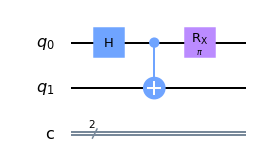

In [58]:
circuit=QuantumCircuit(2,2)
circuit.h(0)
circuit.cx(0, 1)
circuit.rx(np.pi, 0)
circuit.draw('mpl')

### Implement the ansatz as a function in python

This to be done so that it can be called upon to use theta as a parameter, as qiskit doesn't allow the RX parameter to be a variable.

In [59]:
def ansatz(circuit, theta):
    q = circuit.qregs[0]
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.rx(theta, q[0])
    return circuit

### Implementing a function that sets up the measurement in the desired basis

for doing this the function that implements our ansatz is called and then unitaries needed to be in the desired basis are added, which returns the quantum circuit necessary for the VQE.

In [60]:
def two_qubit_vqe(theta, basis):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansate in the circuit
    circuit = ansatz(circuit, theta)
    # measurement
    if basis == 'Z':
        circuit.measure(q, c)
    elif basis == 'X':
        circuit.u2(0, np.pi, q[0])
        circuit.u2(0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'Y':
        circuit.u2(0, np.pi/2, q[0])
        circuit.u2(0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    else:
        raise ValueError('Not a valid pauli basis, input should be X,Y or Z, we excluded I because no circuit is needed')

    return circuit

### Defining a function that runs the circuit and calculates the expectation value from the probabilities of each state we measured

In [61]:
def get_expectation(theta, basis):
    
    if basis == 'I':
        return 1
    elif basis == 'Z':
        circuit = two_qubit_vqe(theta, 'Z')
    elif basis == 'X':
        circuit = two_qubit_vqe(theta, 'X')
    elif basis == 'Y':
        circuit = two_qubit_vqe(theta, 'Y')
    else:
        raise ValueError('Not a valid pauli basis, input should be I,X,Y or Z')
    
    shots = 1996 # My birthyear c:
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expected_value = 0
    for event in counts:
        pm = 1
        if event == '01':
            pm = -1
        if event == '10':
            pm = -1
        expected_value += pm * counts[event] / shots
        
    return expected_value

Finally the function that calls the previous ones is ran, which measures runs for the circuit for each basis and sums the results times the coefficient that acompanies each term in our hamiltonian for any given value of our variational parameter

In [62]:
def vqe_ground(theta):
        
    ground_I = coeff['II']*get_expectation(theta, 'I')
    ground_Z = coeff['ZZ']*get_expectation(theta, 'Z')
    ground_X = coeff['XX']*get_expectation(theta, 'X')
    ground_Y = coeff['YY']*get_expectation(theta, 'Y')
    
    # summing the measurement results
    sum_ = ground_I+ground_Z+ground_X+ground_Y
    
    return sum_

### Plot: Ground state energy vs the value of $\theta$ 
Since the ansatz has only one parameter $\theta$ and it can take values from 0 to $2 \pi$, to find the minimum plot the calculated ground state energy, vs the value of $\theta$

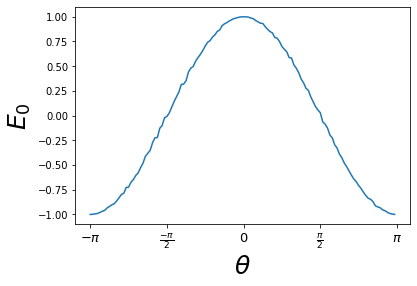

In [63]:
theta=np.arange(-np.pi,np.pi,np.pi/64)
E_0 = [ vqe_ground(i) for i in theta]

plt.plot(theta,E_0)
plt.xlabel(r'$\theta$',fontsize=25)
plt.ylabel(r'$E_{0}$',fontsize=25)
plt.xticks(np.arange(-np.pi,np.pi+1, step=np.pi/2),[r'$-\pi$',r'$\frac{-\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=13)
plt.show()

In case $E_{0}$ is not clear from the plot we call the min function on the values we plotted, and compare with the eigenvalues of the matrix

In [64]:
min(E_0)

-1.00000000000000

In [65]:
Matriz.eigenvals()

{-1: 1, 1: 3}